# Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields

In [93]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

## the implementation of AS method

In [94]:
def AS(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 2) - 256 : int(N / 2) + 256] = np.ones(int(512))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        # limit the bandwidth
        G_z = np.fft.fftshift(G_z)
        f = band_limit
        G_z[0 : 512 + 1 - f] = np.zeros(513 - f)
        G_z[512 + f : 1024] = np.zeros(512 - f)
        G_z = np.fft.ifftshift(G_z)

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return H_FR.real, g_z

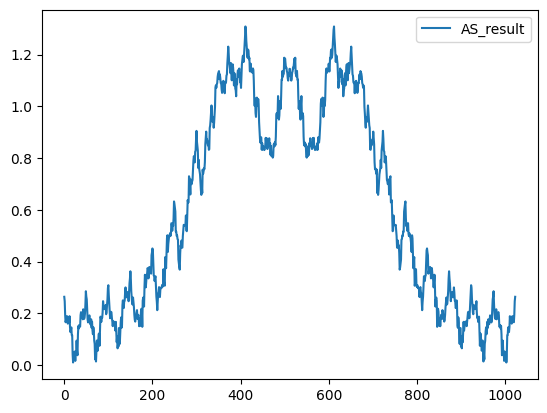

In [95]:
H_FR, g_z_AS = AS()
plt.plot(g_z_AS, label="AS_result")

plt.legend()
plt.show()

## the implementation of numerical integration

In [96]:
from numba import njit


@njit(parallel=True)
def numerical_integration(wave_length=1, n_S=50):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    # real = np.zeros(1024)
    # imag = np.zeros(1024)
    inte_result = np.zeros(1024)

    N = 4000

    g_src = np.zeros(N)
    g_src[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))

    y_real = np.zeros(N)
    y_imag = np.zeros(N)
    x = np.zeros(N)

    d_x = S / N
    for k in range(0, N):
        x[k] = d_x * k

    d_x_dest = 2 * wave_length

    for x_dest_n in range(0, 1024):
        for k in range(0, N):
            r = math.sqrt(z**2 + (x_dest_n * d_x_dest - x[k]) ** 2)
            exp = cmath.exp(2j * math.pi * r / wave_length)
            # print(x_dest_n * d_x_dest - x[k])
            # print(r)
            # print(exp)
            fx = (
                g_src[k]
                * (exp / r)
                * (z / r)
                * (1 / (2 * math.pi * r) + 1 / (1j * wave_length))
            )
            y_real[k] = fx.real
            y_imag[k] = fx.imag
        inte_result[x_dest_n] = abs(np.sum(y_real * d_x) + np.sum(1j * y_imag * d_x))
        # inte_result[x_dest_n] = abs(
        #     np.sum(np.multiply(fx, dx))
        # )
        # real[x_dest_n]=0.5*d_x*(2*np.sum(y_real)-y_real[0]-y_real[-1])
        # imag[x_dest_n]=0.5*d_x*(2*np.sum(y_imag)-y_imag[0]-y_imag[-1])

        inte_result_g = inte_result

    return inte_result_g

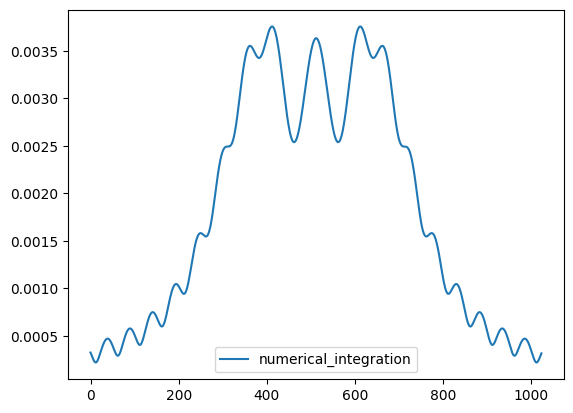

In [97]:
g_z = numerical_integration()
plt.plot(g_z, label="numerical_integration")

plt.legend()
plt.show()

## the AS evaluator

In [109]:
def AS_evaluator(wave_length=1, n_S=50):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024 * 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 2) - 256 : int(N / 2) + 256] = np.ones(int(512))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return g_z[int(N / 2) - 512 : int(N / 2) + 512]

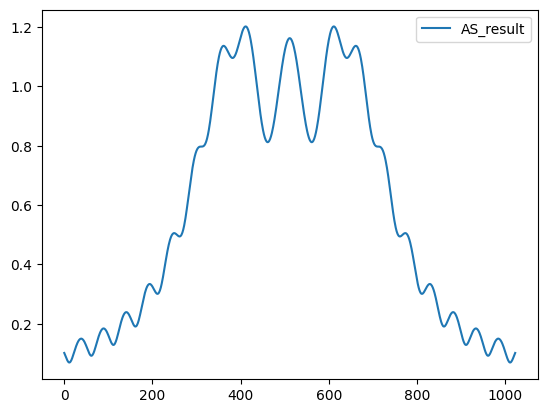

In [130]:
g_z_AS_evaluator = AS_evaluator(1,50)
plt.plot(g_z_AS_evaluator, label="AS_result")

plt.legend()
plt.show()

## the SNR of AS method with different propagation distances

In [111]:
def SNR_cal(signal, noisy_signal):
    signal_power = np.mean(np.square(signal))
    noise_power = np.mean(np.square(noisy_signal - signal))
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [112]:
SNR = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    AS_spectrum, AS_result = AS(1, n_S, -1)
    SNR.append(SNR_cal(AS_evaluator(1, n_S), AS_result))

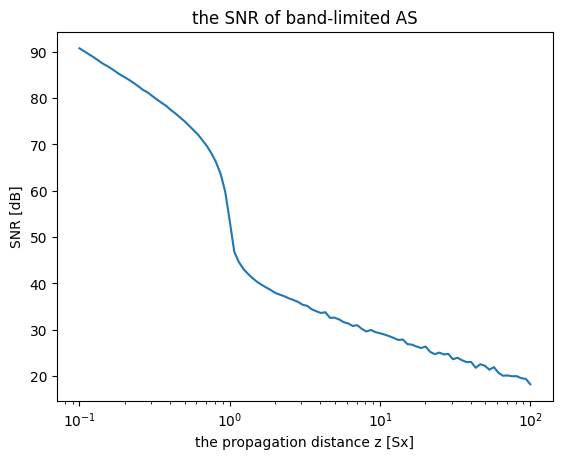

In [113]:
x = 10 ** np.array(n_S_list)
plt.plot(x, SNR)

plt.title("the SNR of band-limited AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")
plt.show()

## improve the SNR by limiting the bandwidth

### implement of band_limited_AS

In [122]:
def band_limited_AS(wave_length, n_S):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq = np.fft.fftshift(freq)

    d_u = 1 / (2 * S)
    u_limit = 1 / (np.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)

    mask = abs(freq) <= (u_limit)
    if np.all(mask):
        clipper_n = -1
    else:
        first_true_index = np.argmax(mask)
        clipper_n = 512 - first_true_index

    H_FR_real, g_z = AS(1, n_S, clipper_n)
    print(f'set clipper_n to be {clipper_n} under cut-off frequency {(u_limit) / 2}')
    return clipper_n, g_z

set clipper_n to be 40 under cut-off frequency 0.00999800059980007


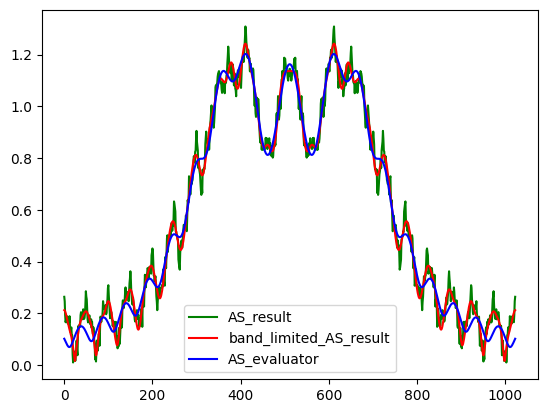

In [123]:
band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, 50)
AS_spectrum, AS_result = AS(1, 50, -1)

plt.plot(AS_result, label="AS_result",color='green')
plt.plot(band_limited_AS_result, label="band_limited_AS_result",color='red')
plt.plot(AS_evaluator(1,50), label="AS_evaluator",color='blue')

plt.legend()
plt.show()

### SNR of band-limited AS with different propagation distance

In [124]:
SNR_band_limited = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, n_S)
    AS_spectrum, AS_result = AS(1, n_S, -1)

    numerical_result = numerical_integration(1, n_S)
    SNR_band_limited.append(SNR_cal(AS_evaluator(1, n_S), band_limited_AS_result))

set clipper_n to be -1 under cut-off frequency 0.49751859510499463
set clipper_n to be -1 under cut-off frequency 0.4971501587866664
set clipper_n to be -1 under cut-off frequency 0.496727556454683
set clipper_n to be -1 under cut-off frequency 0.4962429957986184
set clipper_n to be -1 under cut-off frequency 0.4956876174845783
set clipper_n to be -1 under cut-off frequency 0.49505136606137473
set clipper_n to be -1 under cut-off frequency 0.49432285068255455
set clipper_n to be -1 under cut-off frequency 0.4934891967035236
set clipper_n to be -1 under cut-off frequency 0.49253589003114373
set clipper_n to be -1 under cut-off frequency 0.4914466171769896
set clipper_n to be -1 under cut-off frequency 0.49020310534207134
set clipper_n to be -1 under cut-off frequency 0.48878496858426873
set clipper_n to be -1 under cut-off frequency 0.4871695682232131
set clipper_n to be -1 under cut-off frequency 0.48533189813184285
set clipper_n to be -1 under cut-off frequency 0.483244508421778
set c

the print output above shows different clipper_n regarding to different distance z

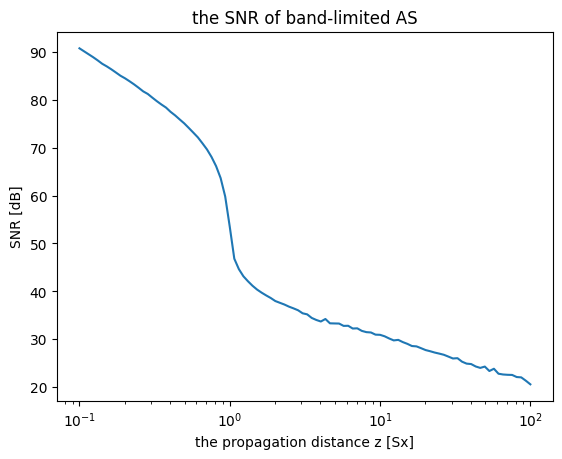

In [125]:
x = 10 ** np.array(n_S_list)
plt.plot(x, SNR_band_limited)

plt.title("the SNR of band-limited AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")

plt.show()

### the improvement from SNR_band_limited compared to the original AS

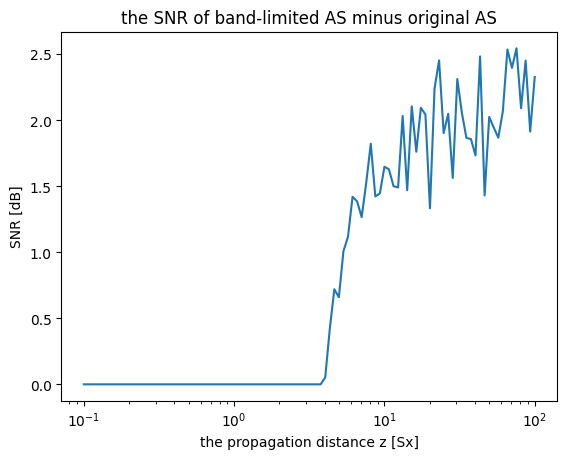

In [126]:
x = 10 ** np.array(n_S_list)
plt.plot(x, np.array(SNR_band_limited) - np.array(SNR))

plt.title("the SNR of band-limited AS minus original AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")

plt.show()

### the clipper's effect on SNR

In [127]:
SNR_clipper = []

n_clipper_list = list(np.linspace(1, 100, 100))
numerical_result = numerical_integration(1, 50)
AS_spectrum, AS_result = AS(1, 50, -1)
evaluator = AS_evaluator(1, 50)

for n_clipper in n_clipper_list:
    band_limited_AS_spectrum, band_limited_AS_result = AS(1, 50, int(n_clipper))
    SNR_clipper.append(SNR_cal(evaluator, band_limited_AS_result))

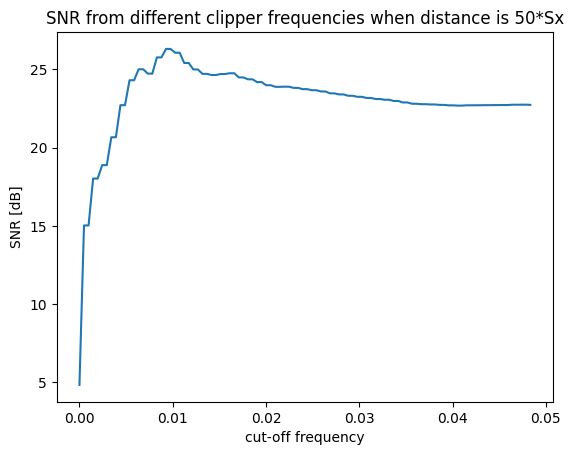

In [128]:
wave_length = 1
dx = 2 * wave_length  # the sampling interval
freq = np.fft.fftfreq(1024, dx)

plt.title("SNR from different clipper frequencies when distance is 50*Sx")
plt.xlabel("cut-off frequency")
plt.ylabel("SNR [dB]")

plt.plot(freq[0:100], SNR_clipper)
plt.show()